In [14]:
file_path = "../../../testdata/test2.nd2"
output_dir = "../../../testdata/test2_output"
metadata_path : str = "../../../testdata/test2_output/test2_metadata.yaml"
corrected_filename = "shading_corrected.zarr"
profile_filename = "shading_profile.zarr"

mode = "additive"
local_subtraction_channels = "*DIA*"
local_subtraction_scaling = 0.1
local_subtraction_median_disk_size=4
num_cpus=10

In [15]:
assert mode in ["multiplicative", "additive"], "mode must be either 'multiplicative' or 'additive'"

In [16]:
from pathlib import Path

def to_path(x):
    return Path(x).absolute()

_file_path = to_path(file_path)
_output_dir = to_path(output_dir)
_metadata_path = to_path(metadata_path)

# Import packages and define functions

In [17]:
from aicsimageio import AICSImage
from matplotlib import pyplot as plt
import numpy as np
from dask import array as da
import re
import zarr
import yaml
from skimage import transform, filters, morphology
from utils import read_mosaic_image, open_zarr_with_synchronizer
from common import match_pattern, shading_correction_chunk
import multiprocessing as mp

import fnmatch

In [18]:
metadata = yaml.safe_load(Path(_metadata_path).read_text())
channel_names = metadata["channel_names"]
mosaic_dim = metadata["mosaic_dim"]
print(channel_names, mosaic_dim)

['10x_Fukai_DIA_IS', '10x_Fukai_DIA_IS', '10x_Fukai_mCherry_IS', '10x_Fukai_EGFP_IS'] scene


# Shading correction

## Open images 

In [19]:
aics_image = AICSImage(_file_path,reconstruct_mosaic=False) 
image = read_mosaic_image(aics_image, mosaic_dim, "TCZYX")

## Output files

In [20]:
chunks = [1] * len(image.shape[:-2]) + list(image.shape[-2:])
zarr_path = _output_dir/corrected_filename
corrected_zarr = open_zarr_with_synchronizer(zarr_path, shape=image.shape, chunks=chunks, dtype=np.float32)

In [21]:
profile_path = _output_dir/profile_filename
profile_zarr = zarr.open(str(profile_path), mode="r")

## Correct shading

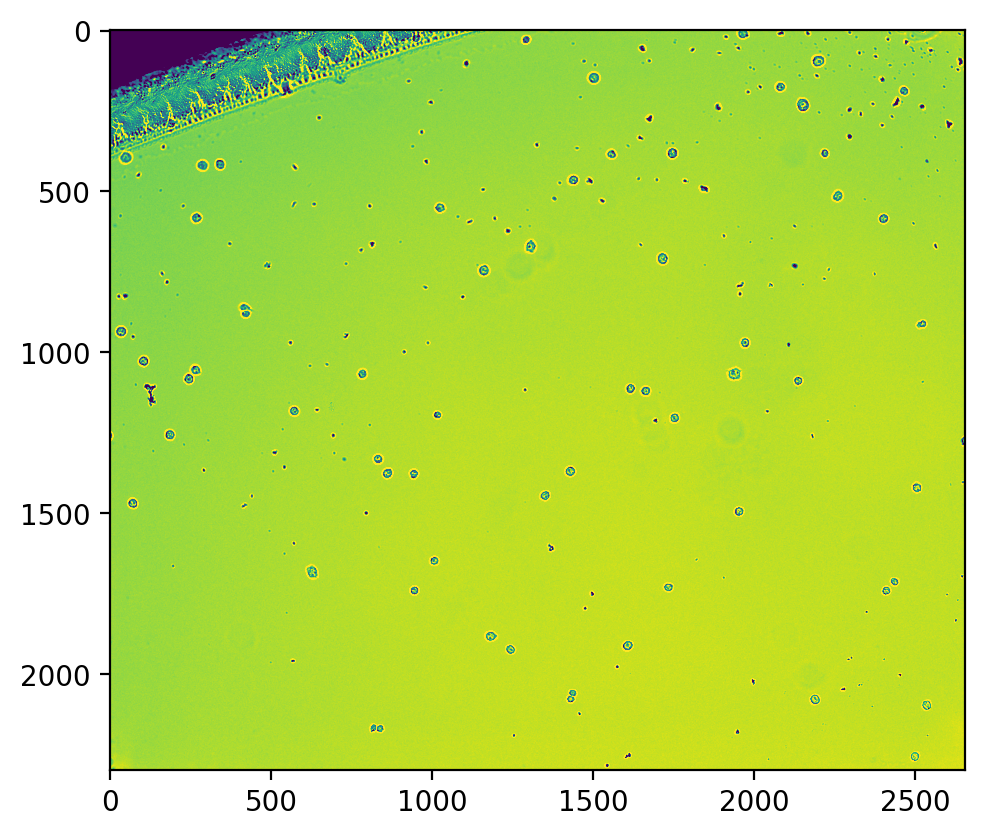

In [22]:
vmin, vmax = np.percentile(np.ravel(image[0,0,0]), (1, 99))
plt.imshow(image[0,0,0,0], vmin=vmin, vmax=vmax)

#### Test with only one image

In [23]:
shading_correction_chunk(
        corrected_zarr, 
        image, 
        profile_zarr, 
        ind = (0,0,0),
        do_local_subtraction = True,
        mode = mode, 
        local_subtraction_scaling=local_subtraction_scaling, 
        local_subtraction_median_disk_size=local_subtraction_median_disk_size)

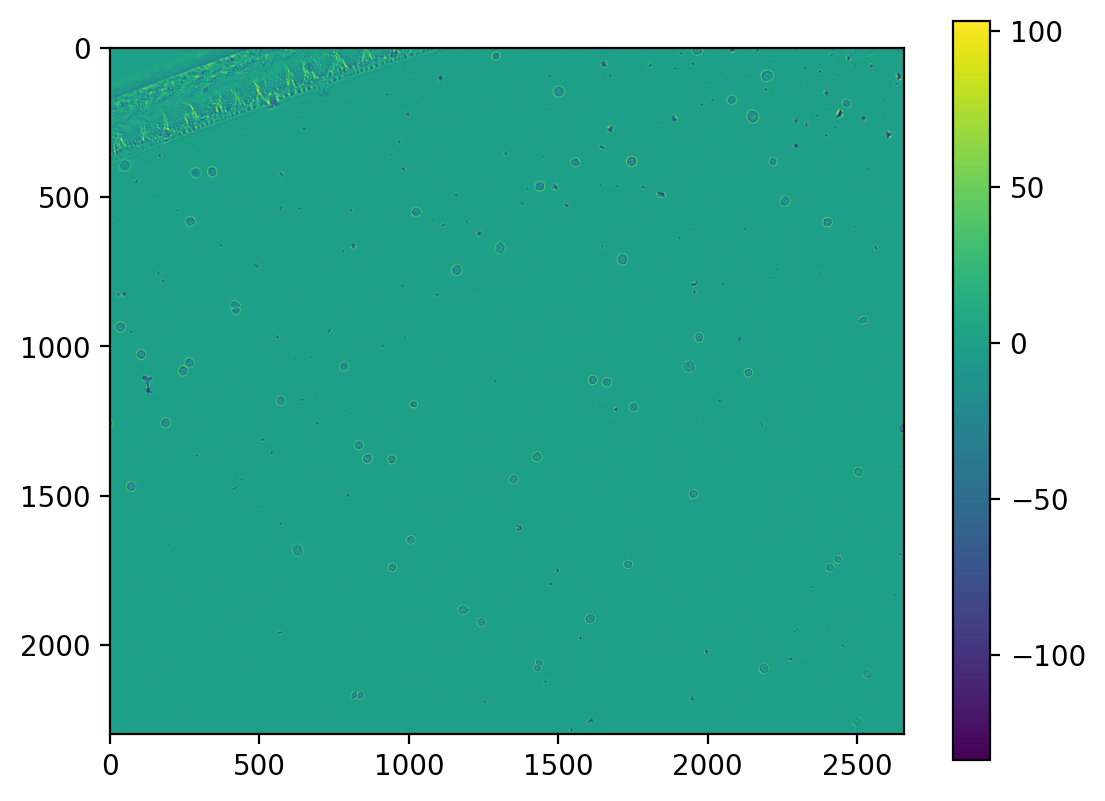

In [24]:
vmin, vmax = np.percentile(np.ravel(corrected_zarr[0,0,0,0]), (0.0001, 99.9999))
plt.imshow(corrected_zarr[0,0,0,0], vmin=vmin, vmax=vmax)
plt.colorbar()

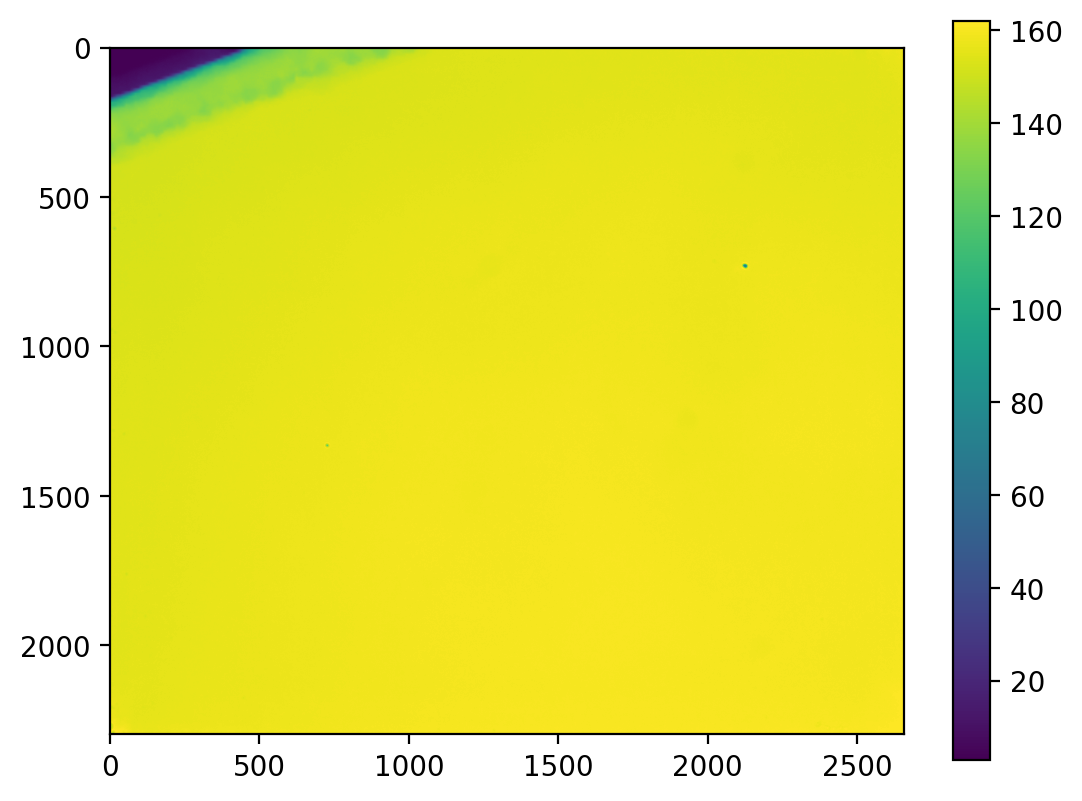

In [25]:
diff = image[0,0,0,0]-corrected_zarr[0,0,0,0]
vmin, vmax = np.percentile(np.ravel(diff), (0.1, 99.9))
plt.imshow(diff,vmin=vmin, vmax=vmax)
plt.colorbar()

#### Process all images

In [31]:
inds = list(np.ndindex(image.shape[:3]))
do_local_subtractions = [local_subtraction_channels == "all" or match_pattern(local_subtraction_channels, channel_names[c]) for (_m,_t,c) in inds]
with mp.Pool(processes=num_cpus) as pool:
    pool.imap(shading_correction_chunk, 
              [(corrected_zarr, 
                image, 
                profile_zarr, 
                ind, 
                do_local_subtraction, 
                mode, 
                local_subtraction_scaling, 
                local_subtraction_median_disk_size) 
               for ind, do_local_subtraction in zip(inds, do_local_subtractions)][:1])


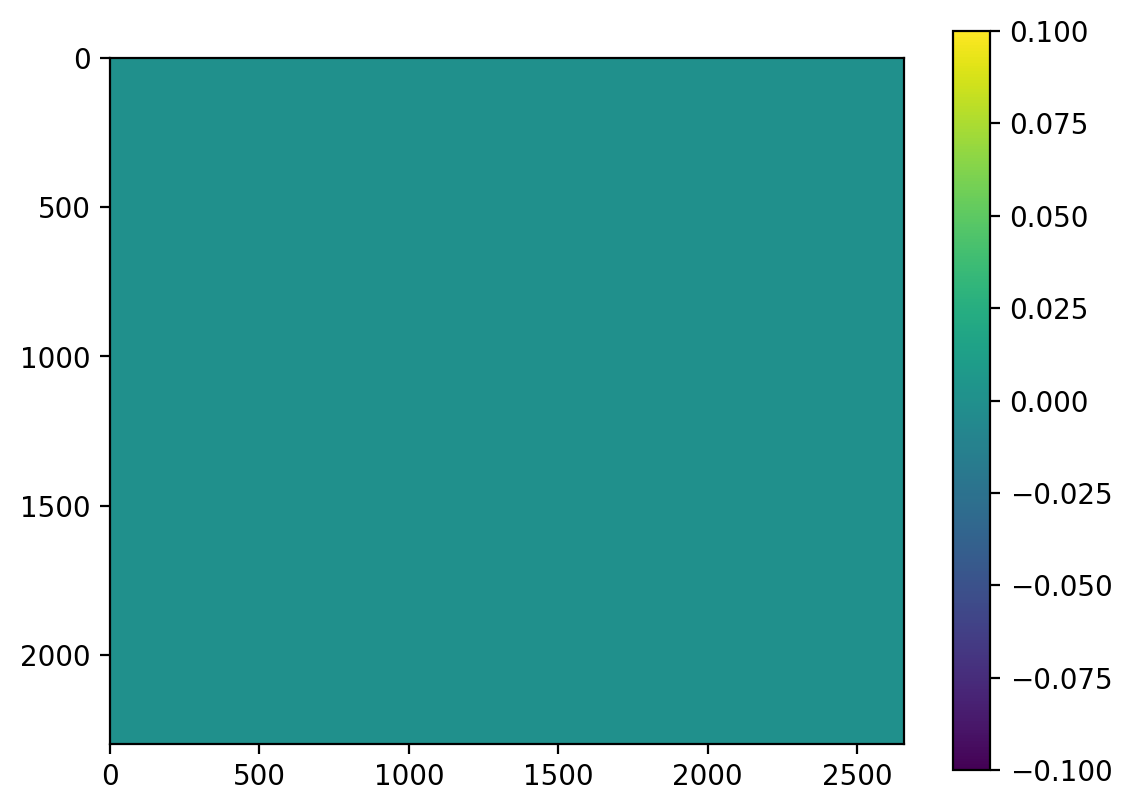

In [ ]:
im = corrected_zarr[0,0,-1,0]
vmin, vmax = np.percentile(np.ravel(im), (0.1, 99.9))
plt.imshow(im,vmin=vmin, vmax=vmax)
plt.colorbar()

In [30]:
list(map(lambda x: shading_correction_chunk(*x), 
                 [(corrected_zarr, 
                   image, 
                   profile_zarr, 
                   ind, 
                   do_local_subtraction, 
                   mode, 
                   local_subtraction_scaling, 
                   local_subtraction_median_disk_size) 
                  for ind, do_local_subtraction in zip(inds, do_local_subtractions)][:1]))

[None]